# Keywords matching and relevance index ranking 

In [1]:
# import packages
import pandas as pd
import numpy as np
import math
from nltk import ngrams
from matplotlib import pyplot as plt
import os
import seaborn as sns

In [2]:
# import internal modules
import file_path_management as fpath
import public_library as plib
import parameters as params
import dataframe_columns as df_col

2023-11-18 00:11:48 GM01X680 metapub.config[186422] WARNING NCBI_API_KEY was not set.


## Predefined fucntions:

In [3]:
def transform(elem):
    return math.log(1 + elem)
# # --------------------start of test code--------------------
# elem = 0
# print(transform(10))
# # ---------------------end of test code---------------------

In [4]:
def relevance_index(counts_dict):
    relevance_index = 0
    
    for key in counts_dict.keys():
        relevance_index += transform(counts_dict[key]) * (params.ranking_kw_groups_weights[key])
    
    return relevance_index
# --------------------start of test code--------------------
# keywords_count_or_fre = {}
# index = calcul_related(keywords_count_or_fre, params.on_topic_kws_weights)
# print(index)
# ---------------------end of test code---------------------

In [5]:
def compute_relevance_index(db_count_path, db_relevance_index_path, rank_by):
    df = pd.read_csv(db_count_path, header=0, sep="\t")
    
    if rank_by == 'tak':
        column_name = '_COUNT_IN_TAK'
    elif rank_by == '500':
        column_name = '_COUNT_IN_500'
    elif rank_by == 'full_text':
        column_name = '_COUNT_IN_FULL_TEXT'
        
    count_dict = {}
    
    for ind in df.index:
        for key in params.ranking_kw_groups.keys():
            # if key == 'INJECT' or 'METHOD':
            #     value = df.at[ind, key+'_COUNT_IN_FULL_TEXT']
            # else:
            #     value = df.at[ind, key+column_name]
            value = df.at[ind, key+column_name]
            
            if value != value:
                value = 0
            count_dict[key] = int(value)
        # print(count_dict)

        relev_index = relevance_index(count_dict)
        
        df.at[ind, "RELEVANCE_INDEX"] = relev_index

        # line_number_in_csv = ind + 1
        # print("Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))
    
    df.columns = df_col.db_ranked_columns
    df.reset_index(drop=True, inplace=True)
    df.to_csv(db_relevance_index_path, header=True, index=False, sep="\t")
    
    # print("Weighting and ranking the potentially related literature succeded!")
    # print("Enjoy reading!")
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_db_kw_count
# output_path = fpath.poten_litera_db_ranked
# rank(input_path, output_path, params.ranking_params_weights)
# ---------------------end of test code---------------------

In [6]:
def rank_and_save(input_path, output_path):
    plib.clear_file(output_path)
    
    # sort
    df_to_rank = pd.read_csv(input_path, header=0, sep="\t")

    # sort by relevance index
    df_to_rank.sort_values(by=['RELEVANCE_INDEX'], ascending=False, inplace=True)
        
    df_to_rank.reset_index(drop=True, inplace=True)
    
    df_to_rank.to_csv(output_path, header=True, index=False, sep="\t")

## Main program:

### 1. Calculate relevance index and rank

In [7]:
rank_by = 'tak'
# rank_by = '500'
# rank_by = 'full_text'

In [8]:
# input_path = fpath.poten_litera_db_kw_count
# relevance_index_path = fpath.poten_litera_db_relevance_index
# plib.clear_file(relevance_index_path)

# # compute relevance index
# compute_relevance_index(input_path, relevance_index_path, rank_by)

# # rank
# if rank_by == 'tak':
#     # rank by tak    
#     rank_and_save(relevance_index_path, fpath.poten_litera_db_ranked_by_tak)
# elif rank_by == '500':
#     # rank by 500    
#     rank_and_save(relevance_index_path, fpath.poten_litera_db_ranked_by_500)
# elif rank_by == 'full_text':
#     # rank by full text
#     rank_and_save(relevance_index_path, fpath.poten_litera_db_ranked_by_full_text)

### 2. Ranking results analysis

In [9]:
# read the labeled testing set
test_path = fpath.poten_litera_testing_set_1000_labeled
df_test = pd.read_csv(test_path, header=0, sep=',')

In [10]:
# initialize lists of the count of keywords in the respective lists

# relevant group
R_species = []
R_other_species = []
R_tc_ct = []
R_thalam = []
R_cortex = []
R_inject = []
R_method = []
R_connectivity = []

# index list of the relevant group
R_index_list = []
# relevance index list of the relevant group
R_relevance_index_list = []

# Irrelevant group
IR_species = []
IR_other_species = []
IR_tc_ct = []
IR_thalam = []
IR_cortex = []
IR_inject = []
IR_method = []
IR_connectivity = []

# index list of the irrelevant group
IR_index_list = []
# relevance index list of the irrelevant group
IR_relevance_index_list = []

In [11]:
# record the count of keywords in the respective lists
if rank_by == 'tak':
    # rank by tak
    df_db_ranked = pd.read_csv(fpath.poten_litera_db_ranked_by_tak, header=0, sep='\t')
    column_name_base = "TAK"
elif rank_by == '500':
    # rank by 500
    df_db_ranked = pd.read_csv(fpath.poten_litera_db_ranked_by_500, header=0, sep='\t')
    column_name_base = "500"
elif rank_by == 'full_text':
    # rank by full_text
    df_db_ranked = pd.read_csv(fpath.poten_litera_db_ranked_by_full_text, header=0, sep='\t')
    column_name_base = "FULL_TEXT"

for ind in df_test.index:
    index = int(df_test.at[ind, "INDEX"])

    if df_test.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y":
        R_index_list.append(index)
        R_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        R_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        R_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        R_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        R_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        R_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        R_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        R_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        R_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])
    else:
        IR_index_list.append(index)
        IR_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        IR_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        IR_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        IR_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        IR_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        IR_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        IR_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        IR_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        IR_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])

In [12]:
# whether to transfer the counts using, for example, log function
tranform = True
# transform = False

In [13]:
# perform the transformation if needed
if tranform:
    # relevant group
    R_species = [transform(elem) for elem in R_species]
    R_other_species = [transform(elem) for elem in R_other_species]
    R_tc_ct = [transform(elem) for elem in R_tc_ct]
    R_thalam = [transform(elem) for elem in R_thalam]
    R_cortex = [transform(elem) for elem in R_cortex]
    R_inject = [transform(elem) for elem in R_inject]
    R_method = [transform(elem) for elem in R_method]
    R_connectivity = [transform(elem) for elem in R_connectivity]

    # irrelevant group
    IR_species = [transform(elem) for elem in IR_species]
    IR_other_species = [transform(elem) for elem in IR_other_species]
    IR_tc_ct = [transform(elem) for elem in IR_tc_ct]
    IR_thalam = [transform(elem) for elem in IR_thalam]
    IR_cortex = [transform(elem) for elem in IR_cortex]
    IR_inject = [transform(elem) for elem in IR_inject]
    IR_method = [transform(elem) for elem in IR_method]
    IR_connectivity = [transform(elem) for elem in IR_connectivity]

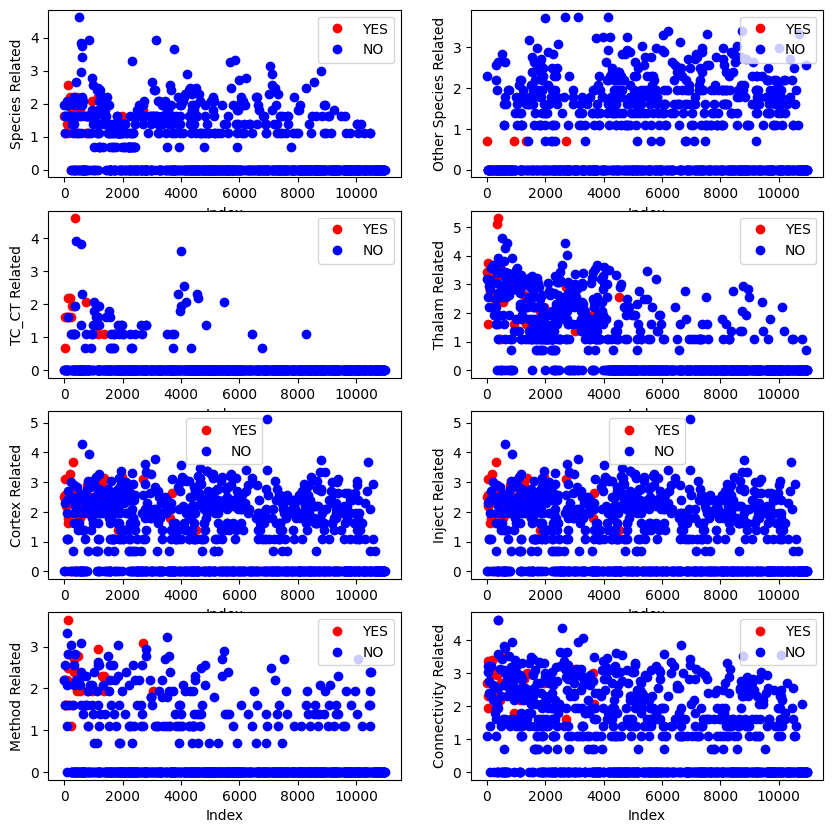

In [14]:
# plot the 8 dot plots
plt.figure(figsize=(10, 10))

plt.subplot(4, 2, 1)
plt.plot(R_index_list, R_species, 'ro', label="YES")
plt.plot(IR_index_list, IR_species, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Species Related")
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(R_index_list, R_other_species, 'ro', label="YES")
plt.plot(IR_index_list, IR_other_species, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Other Species Related")
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(R_index_list, R_tc_ct, 'ro', label="YES")
plt.plot(IR_index_list, IR_tc_ct, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("TC_CT Related")
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(R_index_list, R_thalam, 'ro', label="YES")
plt.plot(IR_index_list, IR_thalam, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Thalam Related")
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(R_index_list, R_cortex, 'ro', label="YES")
plt.plot(IR_index_list, IR_cortex, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Cortex Related")
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(R_index_list, R_cortex, 'ro', label="YES")
plt.plot(IR_index_list, IR_cortex, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Inject Related")
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(R_index_list, R_method, 'ro', label="YES")
plt.plot(IR_index_list, IR_method, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Method Related")
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(R_index_list, R_connectivity, 'ro', label="YES")
plt.plot(IR_index_list, IR_connectivity, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Connectivity Related")
plt.legend()

plt.show()

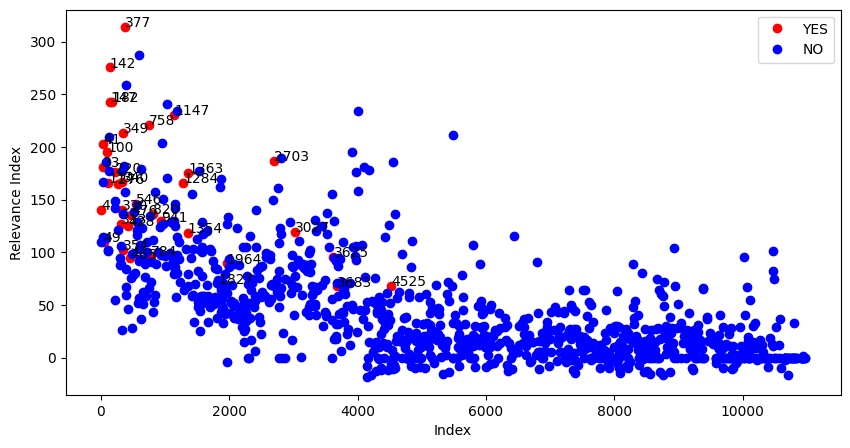

In [15]:
# plot the dot plot of the relevance_index of YESs and NOs of the test data set
plt.figure(figsize=(10, 5))
plt.plot(R_index_list, R_relevance_index_list, 'ro', label="YES")
plt.plot(IR_index_list, IR_relevance_index_list, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Relevance Index")
plt.legend()

# add labels for the relevant index points
for i, index in enumerate(R_index_list):
    plt.text(index, R_relevance_index_list[i]+0.1, str(index), color='black', fontsize=10)

# # add labels for the relevant index points
# for i, index in enumerate(IR_index_list):
#     plt.text(index, IR_relevance_index_list[i], str(index), color='black', fontsize=10)

plt.show()

In [16]:
# min_relevance_index_index = 

# for i in range(len(relvant_index_list)):
#     print(relvant_index_list[i], relevant_relevance_index_list[i])
# print(relevant_relevance_index_list)

min_relevance_index_index = R_index_list[R_relevance_index_list.index(min(R_relevance_index_list))]

for ind in df_db_ranked.index:
    if df_db_ranked.at[ind, "INDEX"] == min_relevance_index_index:
        min_relevance_index_ind = ind
        break 

min_relev_index_num = min_relevance_index_ind  + 1
num = math.ceil(min_relev_index_num * 1.2)
threshold_index = df_db_ranked.at[num-1, 'INDEX']

print(f"The index with the minimum relevance index: {min_relevance_index_index}")
print(f"The number of articles with relevance index larger or equal than that of {min_relevance_index_index}: {min_relev_index_num}")
print(f"The index of the article with the threshold relevance index: {threshold_index}")
print(f"The number of articles to manually check is {num}")

The index with the minimum relevance index: 3683
The number of articles with relevance index larger or equal than that of 3683: 2722
The index of the article with the threshold relevance index: 2006
The number of articles to manually check is 3267


In [17]:
def pick_values_uniformly(data, n):
    """Pick up `n` values uniformly from `data`."""
    if n < 1:
        return []

    # Determine the range of the data
    min_val, max_val = min(data), max(data)

    threshold = (max_val - min_val) / n / 2

    # If n is 1, just return the midpoint
    if n == 1:
        return [(min_val + max_val) / 2]

    # Calculate the interval size
    interval = (max_val - min_val) / (n - 1)

    # Get the uniform values
    return [min_val + i * interval for i in range(n)], threshold

# data = [1, 3, 5, 2, 8, 10, 2]
n = 5
density_display_index, thres = pick_values_uniformly(R_relevance_index_list + IR_relevance_index_list, n)
# print(density_display_index)

Numer of relevant literature: 36
Number of not relevant literature: 964



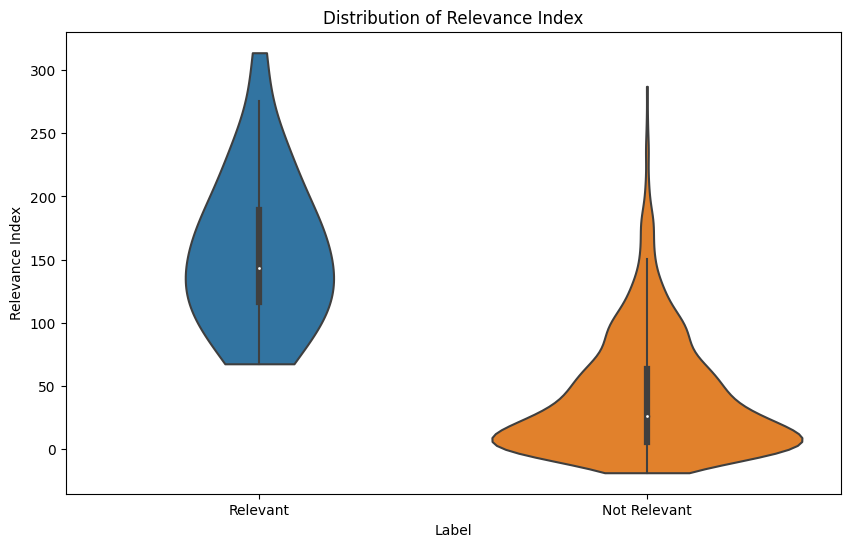

In [18]:
# visualize the distribution of the relevance group and the non-relevance group as violin plots

# Printing the length of lists
print("Numer of relevant literature:", len(R_relevance_index_list))
print("Number of not relevant literature:", len(IR_relevance_index_list))
print()

# Create a DataFrame for plotting
df = pd.DataFrame({'Relevance Index': R_relevance_index_list + IR_relevance_index_list, 
                   'Label': ['Relevant'] * len(R_relevance_index_list) + ['Not Relevant'] * len(IR_relevance_index_list)})

# Draw the violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='Label', y='Relevance Index', data=df, bw='scott', cut=0)

# relevance_indices = density_display_index  # Replace with your relevance indices

# threshold = thres  # Adjust this based on your desired range around the relevance index

# for index in relevance_indices:
#     ax.axhline(index, color='gray', linestyle='--')
    
#     for i, label in enumerate(df['Label'].unique()):
#         # Filter data points close to the current relevance index
#         close_points = df[(df['Label'] == label) & (np.abs(df['Relevance Index'] - index) < threshold)]
#         density = len(close_points)
        
#         ax.text(i, index + 0.1, str(density), ha='center', va='center', color='red', fontsize=9)  # adjust the vertical offset (0.1 here) as necessary

plt.title('Distribution of Relevance Index')
plt.show()

In [19]:
# Check the equality of variances
var_relevant = np.var(R_relevance_index_list)
var_non_relevant = np.var(IR_relevance_index_list)
print('Variance of RELEVANCE_INDEX of the relevant group:', var_relevant)
print('Variance of RELEVANCE_INDEX of the non-relevant group:', var_non_relevant)
print('Ratio of the above variance:', var_relevant/var_non_relevant)

Variance of RELEVANCE_INDEX of the relevant group: 3436.3728812726636
Variance of RELEVANCE_INDEX of the non-relevant group: 2121.18045400376
Ratio of the above variance: 1.6200285434397899


### 3. Prepare the final list of articles to manually read

In [23]:
# # Read the DataFrame from a CSV file
# df = pd.read_csv(fpath.poten_litera_db_ranked_by_tak, header=0, sep='\t')  # Replace with your CSV file path

# index_above_threshold = []
# index_below_threshold = []

# # flag of meet the row where 'INDEX' == min_relevance_index_index
# flag = True

# # Iterate through the DataFrame and add the index to the list
# for ind, row in df.iterrows():
#     index = int(row['INDEX'])
    
#     if flag:
#         index_above_threshold.append(index)
        
#     if index == min_relevance_index_index:
#         index_above_threshold.append(index)
#         flag = False

#     if flag == False and index not in index_above_threshold:
#         index_below_threshold.append(index)

In [24]:
# # add the index of the articles with 'inject' in the full text and articles without full text
# for article_index in index_below_threshold:
#     full_text_file_path = os.path.join(fpath.text_folder, str(article_index), '.text')
    
#     # if the full text file exists
#     if os.path.exists(full_text_file_path):
#         with open(full_text_file_path, 'r', encoding='ascii') as file:
#             # Read the contents of the file
#             text = file.read()
            
#         text = plib.process_text(text, lower=True)
        
#         if 'inject' in text or len(text.split() <= 2000):
#             index_above_threshold.append(article_index)
#     else:
#         index_above_threshold.append(article_index)

In [25]:
# # save the index_above_threshold
# with open(fpath.article_list_to_manually_read, 'w') as file:
#     # Convert each number to string and join them with commas
#     numbers_str = ','.join(map(str, index_above_threshold))
    
#     # Write the string to the file
#     file.write(numbers_str)

<h3> Next step: manually read papers and find all actually related literature </h3>